In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Define Functions

In [2]:
## SCC functions
from SCC_functions import *

In [3]:
## MACC functions and parameters

# default settings
P_50 = 120  # 187.5 * 0.7625000000000001
P_100 = 300  # 187.5
s = 0.05
r = 0.03

def abatement(P, P0, P_50=P_50, r=r, s=s, P_100=P_100):  # 0.05
    if P0 >= P_50:
        print("P0 is greater than P_50")
    elif ((P_100-P0)/(P_50-P0))**(s/r) <= 2:
        print("MAC curve condition not satisfied")
    
    P_h = P0 + ((P_50 - P0) ** (-s / r) - 2 * (P_100 - P0) ** (-s / r)) ** (-r / s)
    Am = 1 + ((P_100 - P0) / (P_h - P0)) ** (-s / r)
    
    A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))
    
    return A

## calculate emissions from forecasted abatement and CO2 baseline

def abatement_to_emissions(forecasted_abatement, CO2_baseline):
    CO2_emissions = CO2_baseline*(1-forecasted_abatement)
    
    return CO2_emissions

# Steps

## 0. Years and Initial Temperature Anomaly

In [4]:
start_year = 2020
end_year = 3000

years = create_years_array(start_year, end_year)
num_of_years = len(years)

In [5]:
## years to calculate SCC
first_perturbed_year = start_year
last_perturbed_year = 2500
year_of_perturbation = create_years_array(start_year, last_perturbed_year)

In [6]:
T_0 = 1.2

## 1. Create Unperturbed Temperature Profile

In [7]:
delta_T = 3
alpha = 0.02
T = create_geometric_T(years, T_0=T_0, alpha=alpha, delta_T=delta_T)

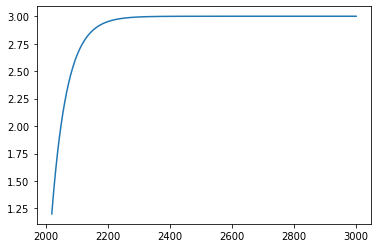

In [8]:
plt.plot(years, T)

## Total Consumption

In [9]:
consumption_growth = 0.02

In [10]:
W = create_total_consumption(years, W_fixed_year=2020, W_fixed=80, consumption_growth=consumption_growth)

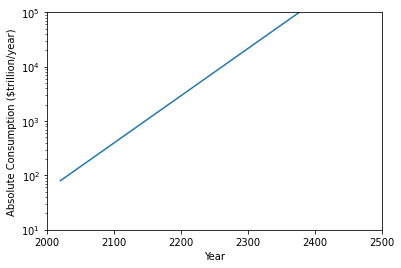

In [11]:
plt.plot(years, W)
plt.xlabel("Year")
plt.ylabel("Absolute Consumption ($trillion/year)")
# plt.xlim(2000, 2100)
# plt.ylim(0, 400)
plt.xlim(2000, 2500)
plt.ylim(10, 100000)
plt.yscale("log")

alternative functional form for above for the fast transition

## 2. Calculate SCC as a function of time for a range of years

In [12]:
T_TCRE_1 = 0.00045
k_s = 0.12
size_of_perturbation = 1

In [13]:
gamma = 2
D0 = 0.00236

In [14]:
# consumption_discount = 0.035
consumption_discount = consumption_growth + 0.015

In [15]:
# consumption_discount = 0.035
# consumption_discount = consumption_growth + 0.015

SCC_list = []

for j in range(len(year_of_perturbation)):
    T_perturbed = perturb_T_geometrically(years, T=T, perturbed_year=year_of_perturbation[j], T_TCRE_1=T_TCRE_1, size_of_perturbation=size_of_perturbation, k_s=k_s)
    discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)
    
    time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T, 'T perturbed': T_perturbed}

    time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

    SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)
    
    if j  == 0:
        print(SCC)
        print(time_series_df)

    if SCC < P_100:
        SCC_list.append(SCC)
    else:
        SCC_list.append(P_100)
        break

23.442601194891857
                  W  discount function         T  T perturbed
years                                                        
2020   8.000000e+01       1.000000e+00  1.200000     1.200000
2021   8.161611e+01       9.656054e-01  1.235642     1.235693
2022   8.326486e+01       9.323938e-01  1.270579     1.270675
2023   8.494692e+01       9.003245e-01  1.304824     1.304960
2024   8.666297e+01       8.693582e-01  1.338391     1.338562
...             ...                ...       ...          ...
2996   2.401697e+10       1.460496e-15  3.000000     3.000450
2997   2.450215e+10       1.410263e-15  3.000000     3.000450
2998   2.499712e+10       1.361758e-15  3.000000     3.000450
2999   2.550210e+10       1.314921e-15  3.000000     3.000450
3000   2.601728e+10       1.269695e-15  3.000000     3.000450

[981 rows x 4 columns]


In [16]:
SCC_array = np.asarray(SCC_list)  # convert to numpy array

Text(0, 0.5, 'SCC ($)')

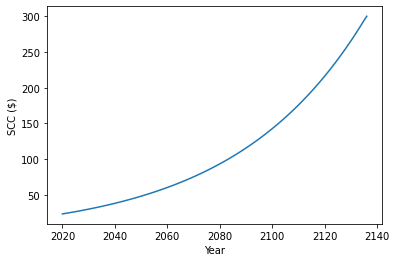

In [17]:
plt.plot(year_of_perturbation[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")

### Check 100% abatement has been achieved!

In [18]:
if SCC_array[-1] < P_100:
    print("P_100 not achieved by achieved by final perturbed year")

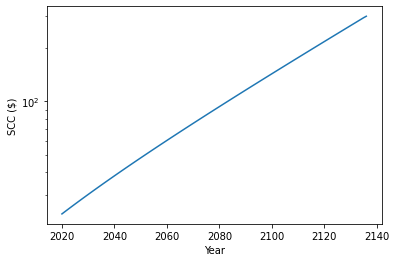

In [19]:
plt.plot(years[:len(SCC_array)], SCC_array)
plt.xlabel("Year")
plt.ylabel("SCC ($)")
plt.yscale("log")

In [20]:
SCC_array

array([ 23.44260119,  24.05278291,  24.67529111,  25.3103748 ,
        25.95828802,  26.61928995,  27.29364499,  27.9816229 ,
        28.68349888,  29.39955368,  30.13007374,  30.87535127,
        31.6356844 ,  32.41137727,  33.20274015,  34.01008962,
        34.83374861,  35.67404661,  36.53131974,  37.40591092,
        38.29817   ,  39.2084539 ,  40.13712673,  41.08455999,
        42.05113264,  43.03723135,  44.04325055,  45.06959267,
        46.11666826,  47.18489615,  48.27470367,  49.38652673,
        50.52081009,  51.67800746,  52.85858176,  54.06300521,
        55.2917596 ,  56.54533645,  57.82423721,  59.12897345,
        60.46006708,  61.81805055,  63.20346708,  64.61687085,
        66.05882724,  67.52991304,  69.03071671,  70.56183859,
        72.12389114,  73.71749921,  75.34330026,  77.00194462,
        78.69409578,  80.42043062,  82.18163968,  83.97842748,
        85.81151275,  87.68162874,  89.58952353,  91.5359603 ,
        93.52171764,  95.54758988,  97.61438738,  99.72

In [21]:
SCC_forecasted = []

for i in range(num_of_years):
    if i < len(SCC_array):
        SCC_forecasted.append(SCC_array[i])
    else:
#         SCC_forecasted.append(SCC_array[-1])
        SCC_forecasted.append(P_100)

SCC_forecasted = np.array(SCC_forecasted)

## 3. Abatement as a function of time

In [22]:
P0 = SCC_forecasted[0]

In [23]:
forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)  # , r=consumption_discount

/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32619/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


problems with certain values due to constraints of the model

Text(0, 0.5, 'Abatement')

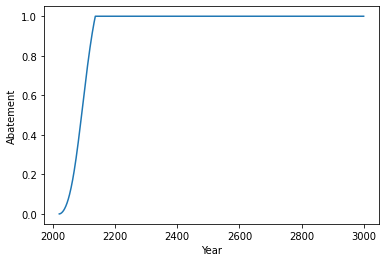

In [24]:
plt.plot(years[:len(forecasted_abatement)], forecasted_abatement)
plt.xlabel("Year")
plt.ylabel("Abatement")

In [25]:
forecasted_abatement

array([0.00000000e+00, 1.78582966e-04, 5.76360877e-04, 1.15154481e-03,
       1.89051748e-03, 2.78699241e-03, 3.83807609e-03, 5.04279669e-03,
       6.40140347e-03, 7.91498229e-03, 9.58522324e-03, 1.14142697e-02,
       1.34046143e-02, 1.55590239e-02, 1.78804830e-02, 2.03721489e-02,
       2.30373156e-02, 2.58793834e-02, 2.89018321e-02, 3.21081974e-02,
       3.55020495e-02, 3.90869722e-02, 4.28665439e-02, 4.68443191e-02,
       5.10238096e-02, 5.54084668e-02, 6.00016637e-02, 6.48066769e-02,
       6.98266688e-02, 7.50646692e-02, 8.05235580e-02, 8.62060462e-02,
       9.21146583e-02, 9.82517140e-02, 1.04619310e-01, 1.11219302e-01,
       1.18053286e-01, 1.25122584e-01, 1.32428222e-01, 1.39970916e-01,
       1.47751056e-01, 1.55768689e-01, 1.64023504e-01, 1.72514821e-01,
       1.81241574e-01, 1.90202300e-01, 1.99395131e-01, 2.08817782e-01,
       2.18467542e-01, 2.28341272e-01, 2.38435396e-01, 2.48745899e-01,
       2.59268328e-01, 2.69997791e-01, 2.80928957e-01, 2.92056067e-01,
      

## 4. Abatement to emissions

In [26]:
CO2_baseline = 40

In [27]:
forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

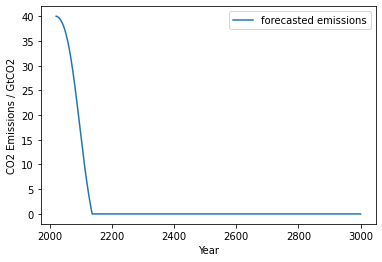

In [28]:
# plt.plot(ssp245_CO2_past, label="historical emissions")
plt.plot(years[:len(forecasted_emissions)], forecasted_emissions, label="forecasted emissions")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions / GtCO2")
plt.legend()

In [29]:
forecasted_emissions

array([40.        , 39.99285668, 39.97694556, 39.95393821, 39.9243793 ,
       39.8885203 , 39.84647696, 39.79828813, 39.74394386, 39.68340071,
       39.61659107, 39.54342921, 39.46381543, 39.37763904, 39.28478068,
       39.18511405, 39.07850738, 38.96482466, 38.84392672, 38.7156721 ,
       38.57991802, 38.43652111, 38.28533824, 38.12622724, 37.95904762,
       37.78366133, 37.59993345, 37.40773292, 37.20693325, 36.99741323,
       36.77905768, 36.55175815, 36.31541367, 36.06993144, 35.8152276 ,
       35.55122793, 35.27786855, 34.99509663, 34.70287112, 34.40116336,
       34.08995776, 33.76925245, 33.43905982, 33.09940715, 32.75033704,
       32.39190799, 32.02419475, 31.64728874, 31.26129832, 30.86634913,
       30.46258418, 30.05016404, 29.62926686, 29.20008836, 28.76284171,
       28.31775732, 27.86508264, 27.40508173, 26.9380349 , 26.46423813,
       25.98400252, 25.49765362, 25.00553064, 24.50798566, 24.00538274,
       23.49809694, 22.98651335, 22.47102596, 21.95203661, 21.42

## 5. Cumulative Emissions to Temperature Change

In [30]:
T_forecast = np.ones(num_of_years)*T_0

for i in range(len(forecasted_emissions)):
    emission_size = forecasted_emissions[i]
    if emission_size != 0:
        T_forecast = perturb_T_geometrically(years, T=T_forecast, perturbed_year=years[i], T_TCRE_1=T_TCRE_1, k_s=k_s,size_of_perturbation=emission_size)

In [31]:
# create_geometric_T_perturbed(years, T=T_forecast_iteration, SCC_year=year_of_perturbation[j], T_TCRE=T_TCRE_1*size_of_perturbation, k_s=k_s)

In [32]:
T_forecast[-1]

2.4699242596823923

In [33]:
# cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])

In [34]:
# temperature_change = T_TCRE_1*cumulative_emissions_array

In [35]:
# max(temperature_change)

In [36]:
T_forecast_iteration0 = T_forecast

In [37]:
# T_forecast_iteration0 = T_0 + temperature_change
# T_forecast_iteration0_plateau = T_2019 + temperature_change_plateau

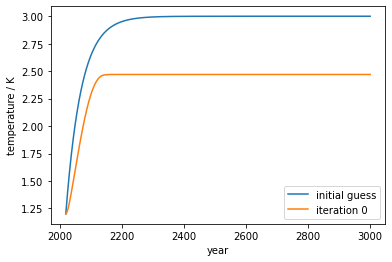

In [38]:
plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_iteration0, label="iteration 0")
# plt.plot(T_forecast_years, T_forecast_iteration0_plateau, label="iteration 0 plateau")
plt.xlabel("year")
plt.ylabel("temperature / K")
plt.legend()

In [39]:
T_forecast

array([1.2       , 1.20203543, 1.20587577, 1.2113161 , 1.21817433,
       1.22628861, 1.2355151 , 1.24572588, 1.2568072 , 1.26865785,
       1.28118775, 1.2943167 , 1.30797323, 1.32209364, 1.33662108,
       1.3515048 , 1.36669944, 1.38216442, 1.39786339, 1.41376372,
       1.42983613, 1.44605425, 1.46239431, 1.47883482, 1.49535633,
       1.51194117, 1.52857325, 1.54523789, 1.56192162, 1.57861207,
       1.59529781, 1.61196826, 1.6286136 , 1.64522463, 1.66179273,
       1.67830981, 1.6947682 , 1.71116062, 1.72748015, 1.74372016,
       1.75987428, 1.7759364 , 1.7919006 , 1.80776114, 1.82351247,
       1.83914918, 1.85466598, 1.87005773, 1.88531938, 1.900446  ,
       1.91543278, 1.93027497, 1.94496793, 1.95950713, 1.97388812,
       1.98810653, 2.0021581 , 2.01603866, 2.02974415, 2.04327058,
       2.05661411, 2.06977098, 2.08273754, 2.09551027, 2.10808578,
       2.12046078, 2.13263215, 2.14459687, 2.15635208, 2.16789507,
       2.17922326, 2.19033424, 2.20122575, 2.21189571, 2.22234

# Iterating Further

In [40]:
# T_forecast_first_loop = T_forecast_iteration0_plateau
# T_forecast_iteration = T_forecast_iteration0_plateau

In [41]:
T_forecast_first_loop = T_forecast_iteration0
T_forecast_iteration = T_forecast_iteration0

19.59699831874365


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32619/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


2.5978608813373425
20.019378448550867


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32619/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


19.912401488914206


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32619/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


19.94017600294987


/var/folders/m4/mbpwp5q15070t8lqj4fj7mjr0000gn/T/ipykernel_32619/2947447235.py:18: RuntimeWarning: divide by zero encountered in power
  A = Am / (1 + ((P - P0) / (P_h - P0)) ** (-s / r))


3


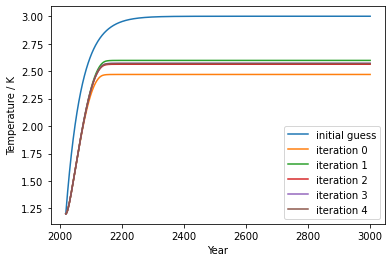

In [42]:
num_of_iterations = 99

first_perturbed_year = start_year

year_of_perturbation = np.arange(first_perturbed_year, last_perturbed_year+1)

plt.plot(years, T, label="initial guess")
plt.plot(years, T_forecast_first_loop, label="iteration 0")

for k in range(num_of_iterations):
#     T_iteration = np.concatenate([T_gas_df['CO2_best'],T_forecast_iteration[1:]])

    SCC_list = []

    for j in range(len(year_of_perturbation)):

        T_perturbed = perturb_T_geometrically(years, T=T_forecast_iteration, perturbed_year=year_of_perturbation[j], T_TCRE_1=T_TCRE_1, size_of_perturbation=size_of_perturbation, k_s=k_s)
        discount_function = create_discount_function(years, year_of_perturbation[j], consumption_discount=consumption_discount)

        time_series_data = {'years': years, 'W': W, 'discount function': discount_function, 'T': T_forecast_iteration, 'T perturbed': T_perturbed}
        time_series_df = pd.DataFrame(data=time_series_data).set_index('years')

        SCC = SCC_calculator(time_series_df, size_of_perturbation=size_of_perturbation, gamma=gamma, D0=D0)

        if j  == 0:
            print(SCC)

        if SCC < P_100:
            SCC_list.append(SCC)
        else:
            SCC_list.append(P_100)
            break

    SCC_array = np.asarray(SCC_list)
    SCC_forecasted = SCC_array
#     SCC_forecasted = []

#     for i in range(num_of_years):
#         if i < len(SCC_array):
#             SCC_forecasted.append(SCC_array[i])
#         else:
#             SCC_forecasted.append(P_100)

#     SCC_forecasted = np.array(SCC_forecasted)
#     print(SCC_forecasted)
#     print(SCC_array) 

    P0 = SCC_forecasted[0]

    forecasted_abatement = abatement(P=SCC_forecasted, P0=P0)
    forecasted_emissions = abatement_to_emissions(forecasted_abatement, CO2_baseline)

#     cumulative_emissions_array = np.append(np.zeros(1), np.cumsum(forecasted_emissions)[:-1])
#     temperature_change = T_TCRE_1*cumulative_emissions_array
    
    T_forecast = np.ones(num_of_years)*T_0
    
    for i in range(len(forecasted_emissions)):
        emission_size = forecasted_emissions[i]
        if emission_size != 0:
            T_forecast = perturb_T_geometrically(years, T=T_forecast, perturbed_year=years[i], T_TCRE_1=T_TCRE_1, k_s=k_s,size_of_perturbation=emission_size)

#     for i in range(len(forecasted_emissions)):
#         size_of_perturbation_cumulative = forecasted_emissions[i]
#         T_forecast = perturb_T_geometrically(years, T=T_forecast, perturbed_year=years[i], T_TCRE_1=T_TCRE_1, k_s=k_s, size_of_perturbation=size_of_perturbation_cumulative)
    
#     T_forecast_iteration = T_0 + temperature_change
    T_forecast_iteration = T_forecast
#     print(T_forecast_iteration)
    
    plt.plot(years, T_forecast_iteration, label="iteration "+str(k+1))
    
    if k == 0:
        peak_T = sum(forecasted_emissions) * T_TCRE_1 + T_0
        print(peak_T)
    else:
        previous_peak_T = peak_T
        peak_T = sum(forecasted_emissions) * T_TCRE_1 + T_0
        if abs(peak_T - previous_peak_T) < 0.005:
            print(k)
            break
    
    if k == num_of_iterations - 1:
        print("convergence condition not achieved")
        print(f"{consumption_discount=}")
        print(f"{consumption_growth=}")
        print(f"{P_50=}")
        print(f"{s=}")
        print(f"{r=}")
        print(f"{P_100=}")

plt.xlabel("Year")
plt.ylabel("Temperature / K")
plt.legend()

***this is fairly analogous to the Newton-Raphson Method***
- the initial temperature profile is essentially just a starting guess; getting pushed toward temperature profile solution
- could stop the iterations when the difference between two consecutive lines is small

In [43]:
## peak Temperature
peak_T

2.5696260200656615

under default settings: 2.5696260200656615